In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from util import constraint_matrix_to_rules, RuleClassifier, calc_ground_truth_constraints
from surrogate_tree import tree_to_constraint_matrix
from tasks.running_example import make_task

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

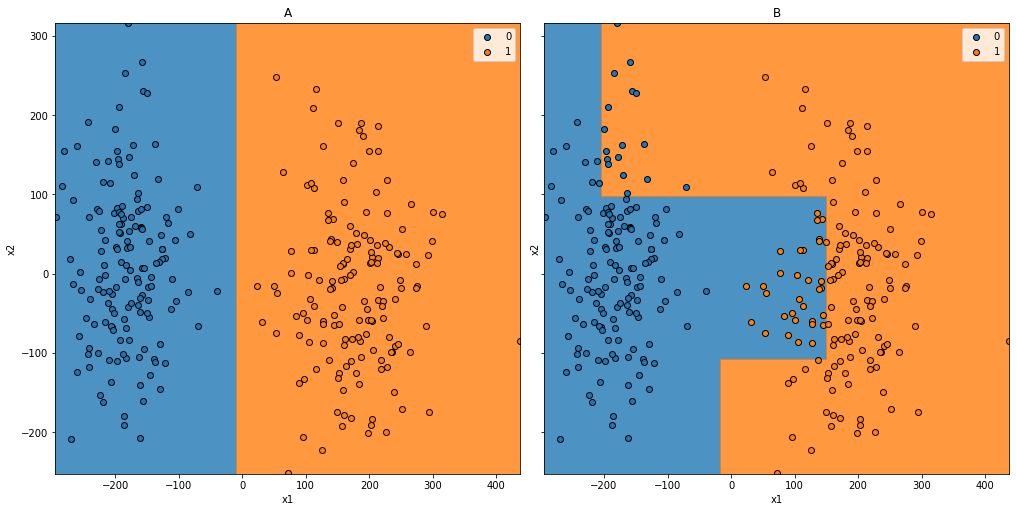

In [4]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

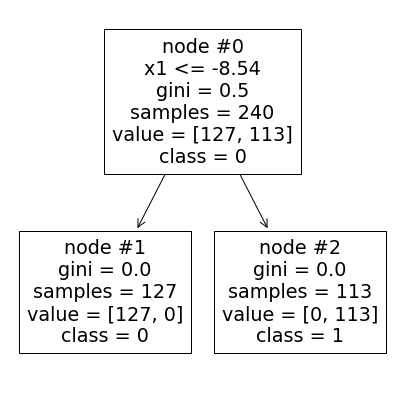

In [5]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_tree(comparer.clf_a, feature_names=comparer.feature_names, class_names=comparer.base_class_names, ax=ax, node_ids=True, precision=2);

Classifier A is a decision tree with just one node. It can be described with one simple rule.

In [7]:
constraints_a, class_occurences_a, labels_a, node_ids_a = tree_to_constraint_matrix(clf_a)
rules_a = constraint_matrix_to_rules(constraints_a, feature_names)
rules_a = [rule for rule, label in zip(rules_a, labels_a) if label == 1 ]
rules_a

['x1 > -8.544832229614258']

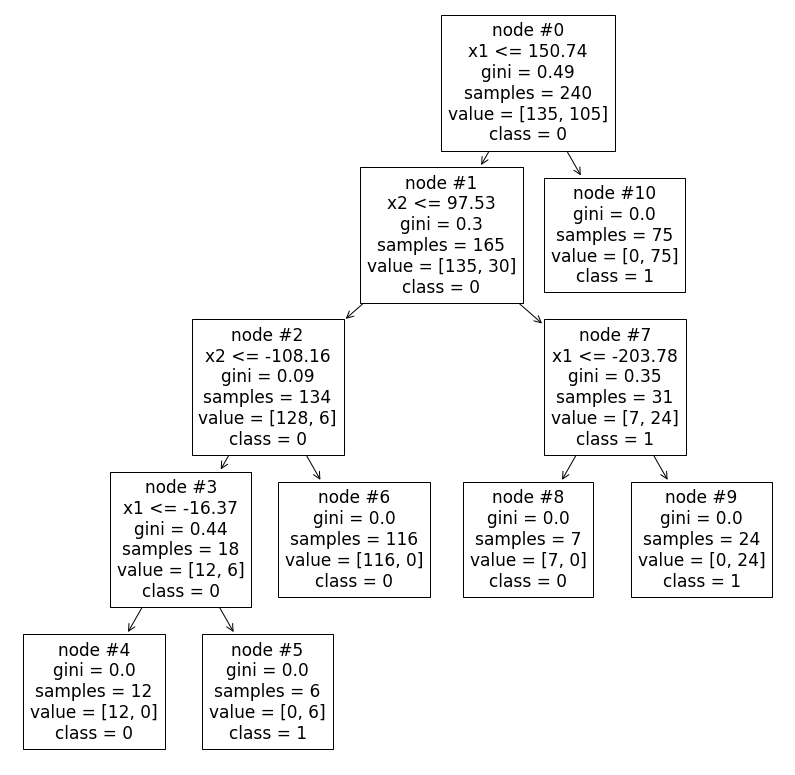

In [8]:
fig, ax = plt.subplots(figsize=(14, 14))
plot_tree(comparer.clf_b, feature_names=comparer.feature_names, class_names=comparer.base_class_names, ax=ax, node_ids=True, precision=2);

Whereas model B needs three rules:

In [9]:
constraints_b, class_occurences_b, labels_b, node_ids_b = tree_to_constraint_matrix(clf_b)
rules_b = constraint_matrix_to_rules(constraints_b, feature_names)
rules_b = [rule for rule, label in zip(rules_b, labels_b) if label == 1 ]
rules_b

['-16.36835479736328 < x1 <= 150.74215698242188 and x2 <= -108.15950393676758',
 '-203.77635192871094 < x1 <= 150.74215698242188 and x2 > 97.53022003173828',
 'x1 > 150.74215698242188']

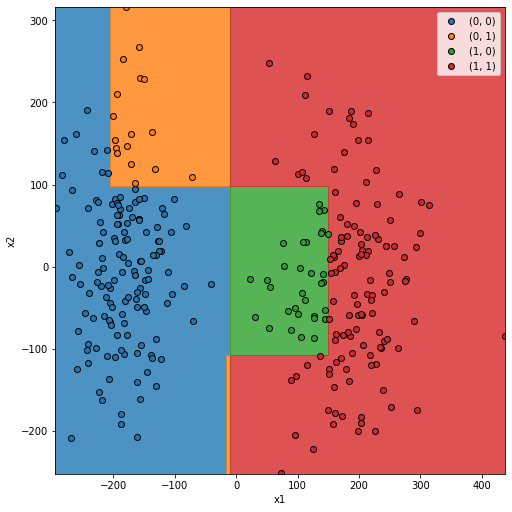

In [10]:
comparer.plot_decision_boundaries(X)

In [11]:
rules_01 = ['-203.77635192871094 < x1 <= -8.544832229614258 and x2 > 97.53022003173828',
            '-16.36835479736328 < x1 <= -8.544832229614258 and x2 <= -108.15950393676758']

In [12]:
rules_10 = ['-8.544832229614258 < x1 <= 150.74215698242188 and -108.15950393676758 < x2 <= 97.53022003173828']

Rule 2 of $(0,1)$ is a bonus task: There are no instances in the data set that fall into the range of the rule.

This is the minimal set of rules that describes the differences. A selected explanation should have no more than these too.

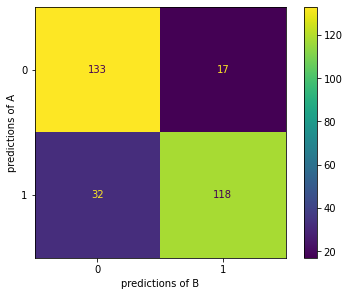

In [13]:
comparer.plot_confusion_matrix(X)

# Ground Truth

In [14]:
%%time
for label in comparer.difference_class_names:
    print(label)
    ground_truth_instance_indices, ground_truth = calc_ground_truth_constraints(comparer, feature_precisions, X, label)
    with open(f'ground_truth.{label}.pickle', 'wb') as f:
        pickle.dump((ground_truth_instance_indices, ground_truth), f)
    rules = constraint_matrix_to_rules(ground_truth, feature_names)
    for instance_idx, rule in zip(ground_truth_instance_indices, rules):
        print(f'{instance_idx}: {rule}')
    print()

(0, 1)
33: -203.8 < x1 <= -8.6 and x2 > 97.5
60: -203.8 < x1 <= -8.6 and x2 > 97.5
68: -203.8 < x1 <= -8.6 and x2 > 97.5
97: -203.8 < x1 <= -8.6 and x2 > 97.5
117: -203.8 < x1 <= -8.6 and x2 > 97.5
143: -203.8 < x1 <= -8.6 and x2 > 97.5
154: -203.8 < x1 <= -8.6 and x2 > 97.5
171: -203.8 < x1 <= -8.6 and x2 > 97.5
181: -203.8 < x1 <= -8.6 and x2 > 97.5
183: -203.8 < x1 <= -8.6 and x2 > 97.5
211: -203.8 < x1 <= -8.6 and x2 > 97.5
233: -203.8 < x1 <= -8.6 and x2 > 97.5
245: -203.8 < x1 <= -8.6 and x2 > 97.5
270: -203.8 < x1 <= -8.6 and x2 > 97.5
281: -203.8 < x1 <= -8.6 and x2 > 97.5
285: -203.8 < x1 <= -8.6 and x2 > 97.5
289: -203.8 < x1 <= -8.6 and x2 > 97.5

(1, 0)
3: -8.6 < x1 <= 150.7 and -108.2 < x2 <= 97.5
17: -8.6 < x1 <= 150.7 and -108.2 < x2 <= 97.5
21: -8.6 < x1 <= 150.7 and -108.2 < x2 <= 97.5
49: -8.6 < x1 <= 150.7 and -108.2 < x2 <= 97.5
76: -8.6 < x1 <= 150.7 and -108.2 < x2 <= 97.5
80: -8.6 < x1 <= 150.7 and -108.2 < x2 <= 97.5
110: -8.6 < x1 <= 150.7 and -108.2 < x2 <= 97

# Special Notes on Evaluation

For this task, there is only one explanation level, the global level.

## Counterfactual Fidelity Error

Due to the precision of the evaluation method, a RMSE below 0.1 is considered a perfect description, otherwise it's rounded to 1 decimal.

## Complexity

The complexity metric is calculated excluding rules that target the bonus task to be comparable. For optimal selectiveness, 2 rules and 7 constraints are required in total.

## Novelty

There is an additional test data set with only one instance, which is an outlier. If the rule set is able to correctly classify it (True), it passes this test.

In [15]:
X_test = np.array([[-15, -110]])
comparer.class_names[comparer.predict_mclass_diff(X_test)]

array(['(0, 1)'], dtype='<U6')

In [16]:
rclf = RuleClassifier(feature_names, rules_01)
rclf.predict(X_test)

array([ True])